In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import optimize

sns.set()

In [18]:
from ICGC_data_parser import SSM_Reader

In [36]:
from collections import Counter

def ignore_bad_lines(mutations):
    while True:
        try:
            yield next(mutations)
        except IndexError:
            pass
        except StopIteration:
            break
# ---

from collections import Counter
from ICGC_data_parser import SSM_Reader

# Open the mutations file
mutations = SSM_Reader(filename='/home/ad115/Downloads/ssm_sample_0.1.vcf')

# Fix weird bug due to malformed description headers
mutations.infos['studies'] = mutations.infos['studies']._replace(type='String')

# Fetch recurrence data per mutation
recurrence_distribution = Counter()
for mutation in ignore_bad_lines(mutations):
    try:
        affected_donors = mutation.INFO['affected_donors']
    except KeyError:
        # Ignore malformed line
        continue
        
    recurrence_distribution[affected_donors] += 1


total = sum(recurrence_distribution.values())
for mut_recurrence,n in recurrence_distribution.most_common(10):
    print(f'{n/total :<10.3%} : Mutations recurred in {mut_recurrence} patients.')

91.828%    : Mutations recurred in 1 patients.
6.217%     : Mutations recurred in 2 patients.
1.146%     : Mutations recurred in 3 patients.
0.378%     : Mutations recurred in 4 patients.
0.181%     : Mutations recurred in 5 patients.
0.095%     : Mutations recurred in 6 patients.
0.056%     : Mutations recurred in 7 patients.
0.034%     : Mutations recurred in 8 patients.
0.021%     : Mutations recurred in 9 patients.
0.014%     : Mutations recurred in 10 patients.


In [37]:
for i in sorted(recurrence_distribution.keys()):
    if i > 10:
        break
    print(i, recurrence_distribution[i])

1 7117293
2 481873
3 88811
4 29308
5 13999
6 7378
7 4322
8 2644
9 1656
10 1062


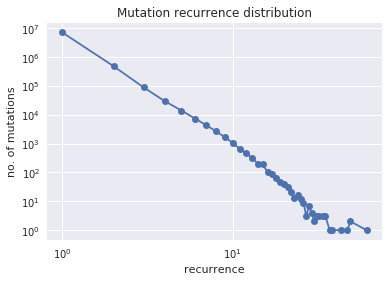

In [38]:
x = sorted(recurrence_distribution.keys())
y = [recurrence_distribution[i] for i in x]

plt.plot(x, y, marker='o')
plt.yscale('log')
plt.xscale('log')
plt.title('Mutation recurrence distribution')
plt.xlabel('recurrence')
plt.ylabel('no. of mutations')
plt.show()

In [39]:
xdata = np.array(x)
ydata = np.array(y)
yerr = 0.2 * ydata

[ 7.10843278 -4.29247346]
[[ 0.01067789 -0.00799416]
 [-0.00799416  0.00660336]]


Text(0,0.5,'Y (log scale)')

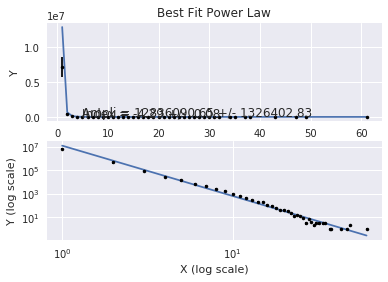

In [41]:
##########
# Fitting the data -- Least Squares Method
##########

# Power-law fitting is best done by first converting
# to a linear equation and then fitting to a straight line.
# Note that the `logyerr` term here is ignoring a constant prefactor.
#
#  y = a * x^b
#  log(y) = log(a) + b*log(x)
#
# Define function for calculating a power law
powerlaw = lambda x, amp, index: amp * (x**index)

logx = np.log10(xdata)
logy = np.log10(ydata)
logyerr = yerr / ydata

# define our (line) fitting function
fitfunc = lambda p, x: p[0] + p[1] * x
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

pinit = [1.0, -1.0]
out = optimize.leastsq(errfunc, pinit,
                       args=(logx, logy, logyerr), full_output=1)

pfinal = out[0]
covar = out[1]
print(pfinal)
print(covar)

index = pfinal[1]
amp = 10.0**pfinal[0]

indexErr = np.sqrt( covar[1][1] )
ampErr = np.sqrt( covar[0][0] ) * amp

##########
# Plotting data
##########

plt.clf()
plt.subplot(2, 1, 1)
plt.plot(xdata, powerlaw(xdata, amp, index))     # Fit
plt.errorbar(xdata, ydata, yerr=yerr, fmt='k.')  # Data
plt.text(5, 50000, 'Ampli = %5.2f +/- %5.2f' % (amp, ampErr))
plt.text(5, 20000, 'Index = %5.2f +/- %5.2f' % (index, indexErr))
plt.title('Best Fit Power Law')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(2, 1, 2)
plt.loglog(xdata, powerlaw(xdata, amp, index))
plt.errorbar(xdata, ydata, yerr=yerr, fmt='k.')  # Data
plt.xlabel('X (log scale)')
plt.ylabel('Y (log scale)')

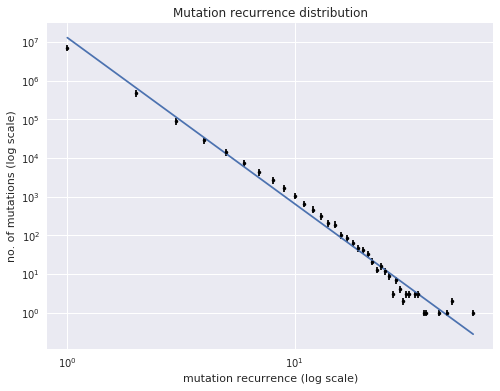

In [42]:
sns.set()

plt.figure(figsize=(8,6))

plt.loglog(xdata, powerlaw(xdata, amp, index))
plt.errorbar(xdata, ydata, yerr=yerr, fmt='k.')  # Data

plt.yscale('log')
plt.xscale('log')

plt.title('Mutation recurrence distribution')
plt.xlabel('mutation recurrence (log scale)')
plt.ylabel('no. of mutations (log scale)')

plt.savefig('recurrence-distribution.png')
plt.show()